### import Module

In [2]:
import requests
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from collections import defaultdict

### Azure Custom Vision API 정보 (사용자가 직접 입력)

In [ ]:
prediction_endpoint = ""
prediction_key = ""
project_id = ""
model_name = ""

STORAGE_CONNECTION_STRING = ""
CONTAINER_NAME = ""
STORAGE_ACCOUNT_NAME = ""

# 2⃣ 엑셀 파일 경로
EXCEL_PATH = "data/updated_clothimage.xlsx"

### Custom Vision 결과 확인

In [4]:
img_num = 10

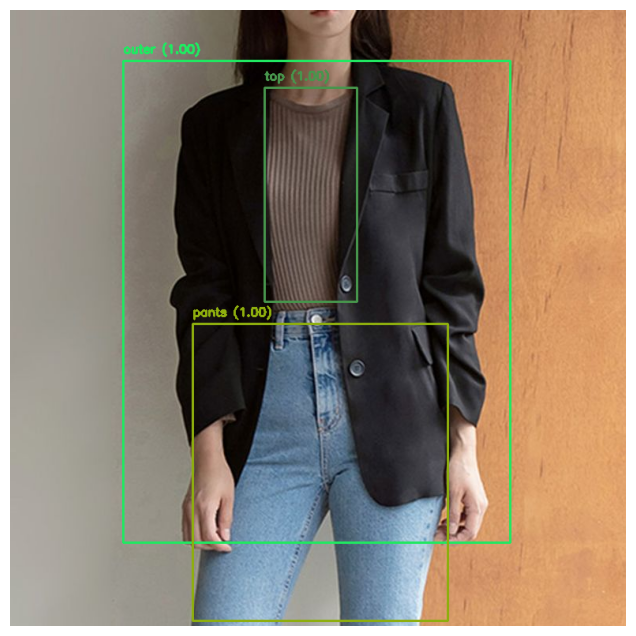

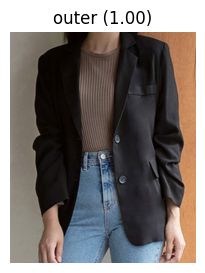

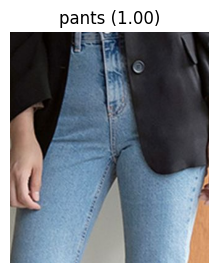

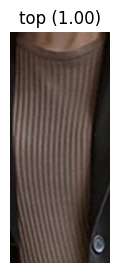

Tag: outer, Probability: 1.00, Image Shape: (610, 490, 3)
Tag: pants, Probability: 1.00, Image Shape: (376, 323, 3)
Tag: top, Probability: 1.00, Image Shape: (271, 117, 3)


In [5]:
## Custom Vision 결과 확인
# 임계값 설정
THRESHOLD = 0.7  # 70% 이상 확률만 표시

# 카테고리별 색상 저장용 딕셔너리
category_colors = defaultdict(lambda: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

def detect_objects(image_path):
    # 이미지 로드
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    # API 요청 헤더 및 데이터
    headers = {
        "Prediction-Key": prediction_key,
        "Content-Type": "application/octet-stream"
    }
    url = f"{prediction_endpoint}/customvision/v3.0/Prediction/{project_id}/detect/iterations/{model_name}/image"
    
    # 요청 전송
    response = requests.post(url, headers=headers, data=image_data)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return None

    # JSON 응답 데이터 파싱
    return response.json()

def visualize_detections(image_path, detections):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < THRESHOLD:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 정보 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 카테고리별 색상 선택
        color = category_colors[tag_name]

        # 바운딩 박스 및 텍스트 추가
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, f"{tag_name} ({probability:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # 결과 시각화
    plt.figure(figsize=(10, 8))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

# 실행 예시
image_file = f"data/musinsa_images_outer/O{img_num}.jpg"
detections = detect_objects(image_file)
if detections:
    visualize_detections(image_file, detections)


## 필요한 부분만 가져오기
def show_cropped_objects_clean(image_path, detections, threshold=THRESHOLD):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cropped_images = []  # 크롭된 이미지를 저장할 리스트

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < threshold:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 좌표 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 객체 부분 잘라내기
        cropped_object = image[y1:y2, x1:x2]
        cropped_images.append((tag_name, probability, cropped_object))  # (라벨, 확률, 이미지) 저장

        # 새 창에 개별 이미지 출력
        plt.figure(figsize=(3, 3))
        plt.imshow(cropped_object)
        plt.title(f"{tag_name} ({probability:.2f})")
        plt.axis("off")
        plt.show()

    return cropped_images  # 크롭된 이미지 리스트 반환

# 실행 예시
cropped_objects = show_cropped_objects_clean(image_file, detections)

# 반환된 이미지 확인
for tag, prob, img in cropped_objects:
    print(f"Tag: {tag}, Probability: {prob:.2f}, Image Shape: {img.shape}")



### Clustering: Mean Shift

[Mean Shift Clustering이란?] <br>
- K-means와 유사한 방식이나 밀도 기반의 접근 방식 이용 <br>
-> K-means: 중심에 소속된 데이터의 평균거리 중심으로 이동 <br>
-> Mean Shift: 데이터가 모여있는 밀도가 가장 높은 곳으로 중심을 이동시킴 <br>

- 별도의 군집화 개수를 지정하지 않고, 데이터 분포도에 기반하여 자동으로 군집 개수 선정
- KDE(Kernel Density Estimation)로 확률 밀도 함수를 찾는 방식으로 밀도 기반 군집 진행

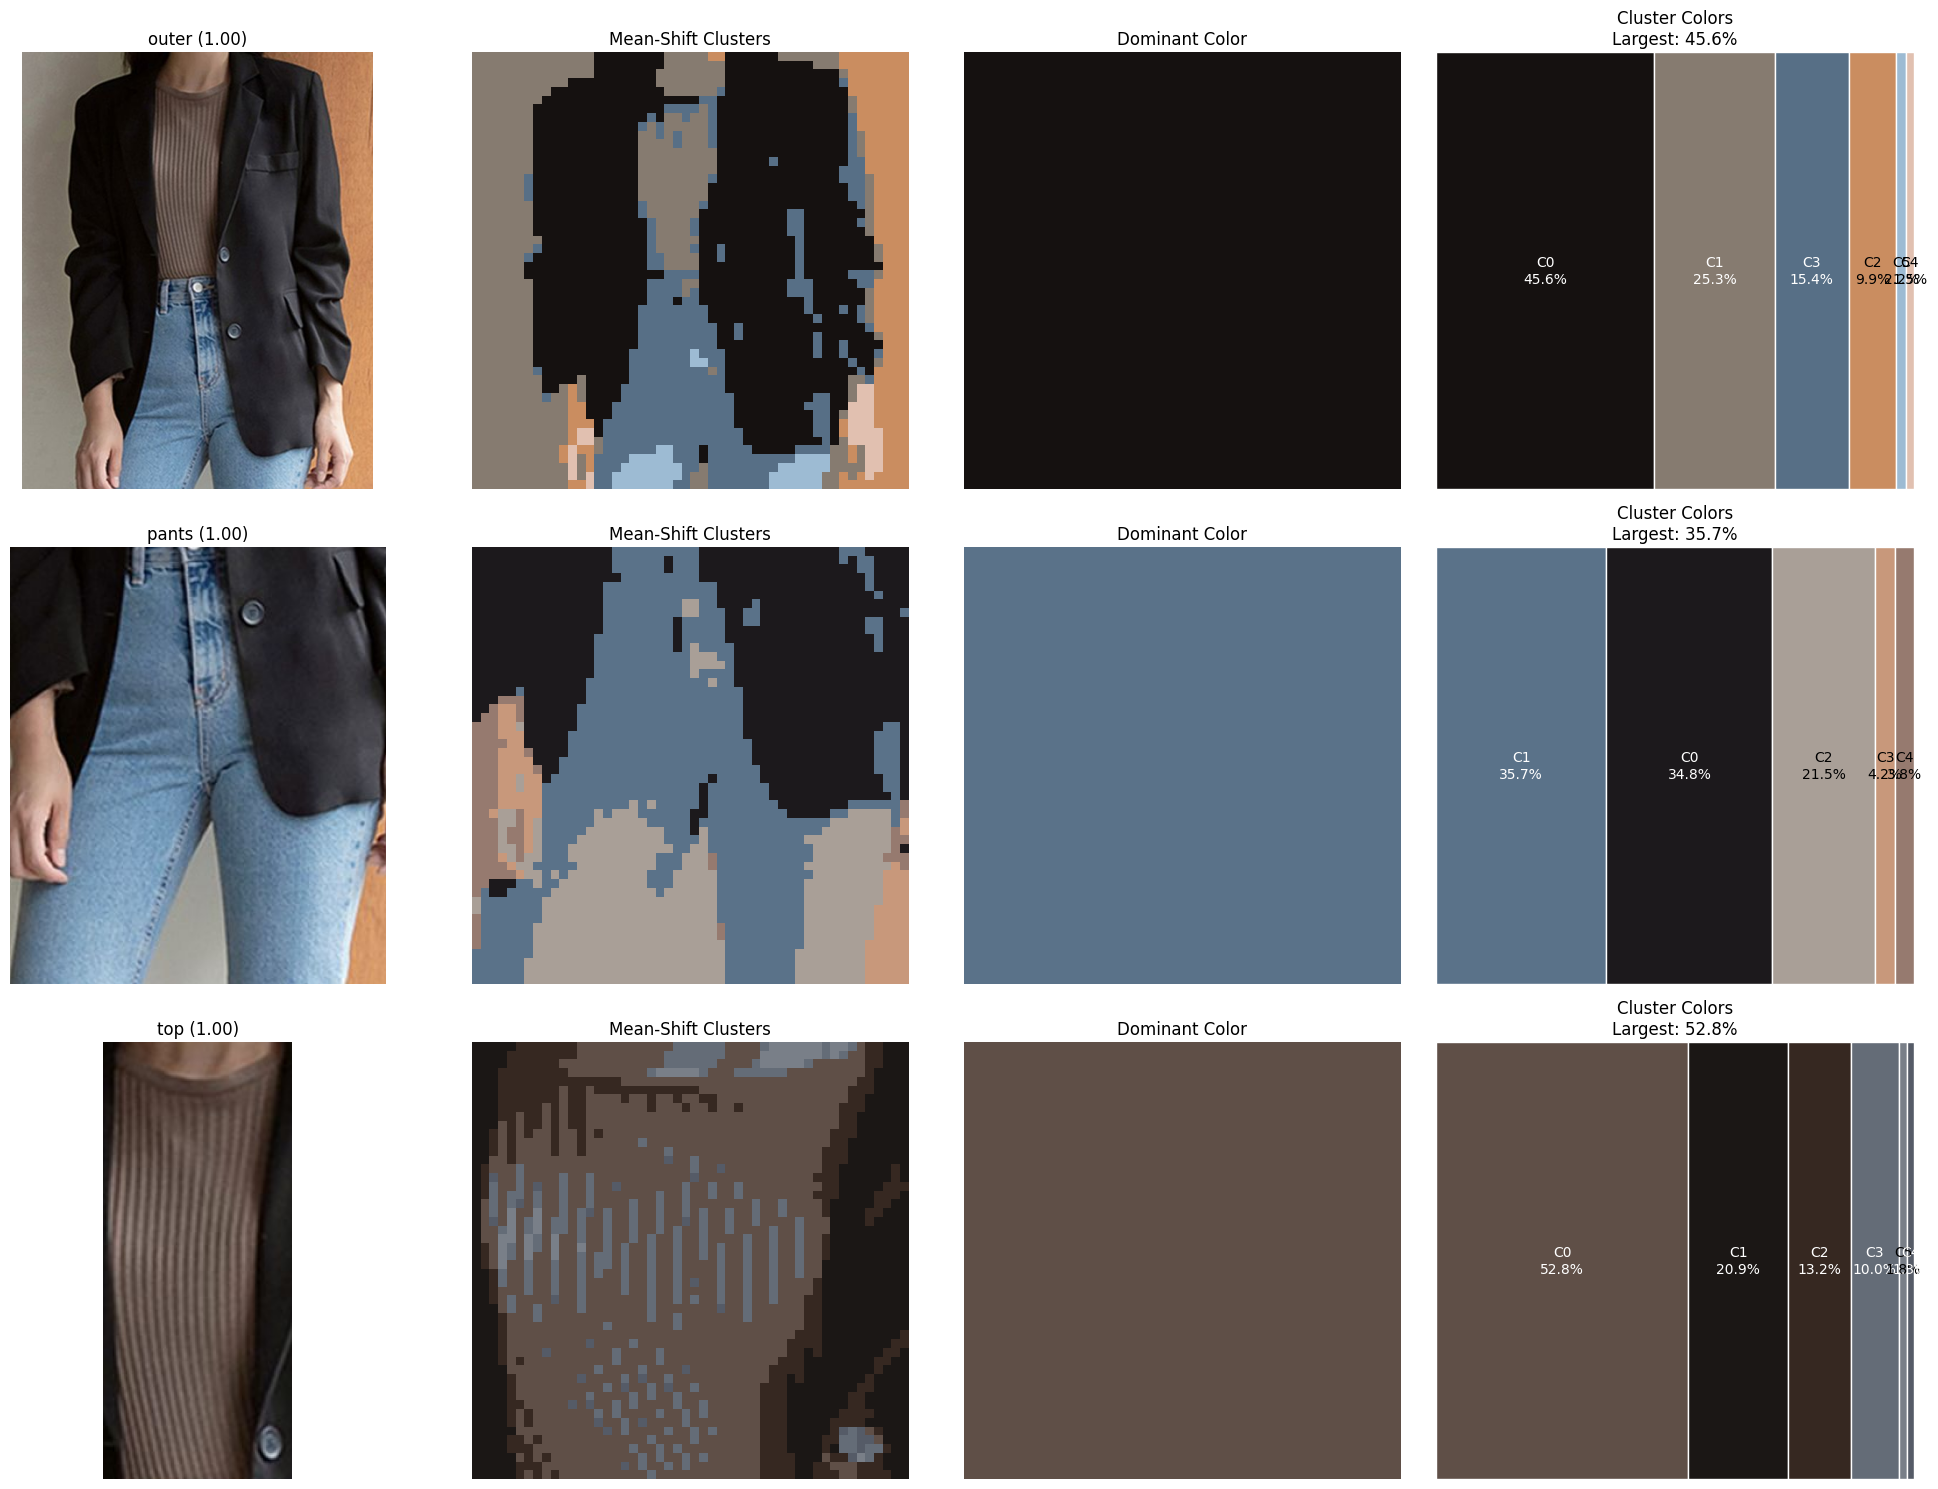

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift, estimate_bandwidth

def plot_cluster_color_bar(ax, sorted_clusters, total_pixels):
    """
    클러스터별 평균 색상과 픽셀 비율을 바탕으로 색상 바를 생성.
    """
    left = 0.0
    for label, (mean_color, count) in sorted_clusters:
        proportion = count / total_pixels
        color = np.array(mean_color) / 255.0
        rect = plt.Rectangle((left, 0), proportion, 1, facecolor=color, edgecolor='white')
        ax.add_patch(rect)
        text_color = 'black' if np.mean(color) > 0.5 else 'white'
        ax.text(left + proportion/2, 0.5, f"C{label}\n{proportion*100:.1f}%", 
                ha='center', va='center', fontsize=10, color=text_color)
        left += proportion
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

def show_all_cropped_visualizations(cropped_objects, quantile=0.15, n_samples=500):
    """
    크롭된 객체들을 Mean-Shift로 분석하여 시각화 (DBSCAN 코드의 형식 유지)
    """
    n = len(cropped_objects)
    if n == 0:
        print("표시할 크롭 이미지가 없습니다.")
        return

    fig, axes = plt.subplots(n, 4, figsize=(20, 5 * n))
    if n == 1:
        axes = np.expand_dims(axes, axis=0)
    
    for i, (tag, prob, img) in enumerate(cropped_objects):
        axes[i, 0].imshow(img)
        axes[i, 0].set_title(f"{tag} ({prob:.2f})")
        axes[i, 0].axis("off")

        small_img = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
        pixels = small_img.reshape(-1, 3)

        bandwidth = estimate_bandwidth(pixels, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = ms.fit_predict(pixels)
        cluster_centers = ms.cluster_centers_.astype(int)

        unique_labels, counts = np.unique(labels, return_counts=True)
        cluster_colors = {label: cluster_centers[label] for label in unique_labels}

        colored_pixels = np.array([cluster_colors[label] for label in labels])
        cluster_image = colored_pixels.reshape(small_img.shape)
        axes[i, 1].imshow(cluster_image.astype(np.uint8))
        axes[i, 1].set_title("Mean-Shift Clusters")
        axes[i, 1].axis("off")

        dominant_label = unique_labels[np.argmax(counts)]
        dominant_color = cluster_centers[dominant_label]
        dominant_patch = np.full((50, 50, 3), dominant_color, dtype=np.uint8)
        axes[i, 2].imshow(dominant_patch)
        axes[i, 2].set_title("Dominant Color")
        axes[i, 2].axis("off")

        total_pixels = len(pixels)
        cluster_info = {label: (cluster_centers[label], count) for label, count in zip(unique_labels, counts)}
        sorted_clusters = sorted(cluster_info.items(), key=lambda x: x[1][1], reverse=True)
        plot_cluster_color_bar(axes[i, 3], sorted_clusters, total_pixels)
        largest_percentage = (sorted_clusters[0][1][1] / total_pixels) * 100
        axes[i, 3].set_title(f"Cluster Colors\nLargest: {largest_percentage:.1f}%")

    plt.tight_layout()
    plt.show()

show_all_cropped_visualizations(cropped_objects, quantile=0.15, n_samples=500)

### 총 정리
- input: image
- output: hex code for each cropped image

In [ ]:
import cv2
import numpy as np
from sklearn.cluster import MeanShift, estimate_bandwidth

## Custom Vision 결과 확인
# 임계값 설정
THRESHOLD = 0.7  # 70% 이상 확률만 표시

# 카테고리별 색상 저장용 딕셔너리
category_colors = defaultdict(lambda: (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)))

def detect_objects(image_path):
    # 이미지 로드
    with open(image_path, "rb") as image_file:
        image_data = image_file.read()

    # API 요청 헤더 및 데이터
    headers = {
        "Prediction-Key": prediction_key,
        "Content-Type": "application/octet-stream"
    }
    url = f"{prediction_endpoint}/customvision/v3.0/Prediction/{project_id}/detect/iterations/{model_name}/image"
    
    # 요청 전송
    response = requests.post(url, headers=headers, data=image_data)
    
    if response.status_code != 200:
        print("Error:", response.text)
        return None

    # JSON 응답 데이터 파싱
    return response.json()

## 필요한 부분만 가져오기
def show_cropped_objects_clean(image_path, detections, threshold=THRESHOLD):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    cropped_images = []  # 크롭된 이미지를 저장할 리스트

    for prediction in detections["predictions"]:
        probability = prediction["probability"]
        if probability < threshold:
            continue  # 임계값보다 낮으면 무시

        tag_name = prediction["tagName"]
        bbox = prediction["boundingBox"]

        # 바운딩 박스 좌표 변환
        h, w, _ = image.shape
        x1, y1 = int(bbox["left"] * w), int(bbox["top"] * h)
        x2, y2 = int((bbox["left"] + bbox["width"]) * w), int((bbox["top"] + bbox["height"]) * h)

        # 객체 부분 잘라내기
        cropped_object = image[y1:y2, x1:x2]
        cropped_images.append((tag_name, probability, cropped_object))  # (라벨, 확률, 이미지) 저장

    return cropped_images  # 크롭된 이미지 리스트 반환

def get_dominant_colors_hex(cropped_objects, quantile=0.15, n_samples=500):
    """
    크롭된 이미지 리스트에서 각 이미지별 대표 색상을 HEX 코드로 반환.

    Args:
        cropped_objects (list of tuples): (tag, probability, cropped_image) 튜플 리스트.
        quantile (float): Mean-Shift의 대역폭 추정을 위한 백분위수.
        n_samples (int): 대역폭 추정을 위한 샘플 개수.

    Returns:
        dict: {tag: hex_color} 형태의 대표 색상 딕셔너리.
    """
    dominant_colors_hex = {}

    for tag, _, img in cropped_objects:
        pixels = img.reshape(-1, 3)  # (H, W, 3) → (N, 3)

        # Mean-Shift 클러스터링
        bandwidth = estimate_bandwidth(pixels, quantile=quantile, n_samples=n_samples)
        ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
        labels = ms.fit_predict(pixels)
        cluster_centers = ms.cluster_centers_.astype(int)

        # 가장 많이 등장한 대표 색상 선택
        unique_labels, counts = np.unique(labels, return_counts=True)
        dominant_label = unique_labels[np.argmax(counts)]
        dominant_color = cluster_centers[dominant_label]

        # BGR → RGB 변환 후 HEX 코드 변환
        hex_color = "#{:02x}{:02x}{:02x}".format(dominant_color[0], dominant_color[1], dominant_color[2])
        dominant_colors_hex[tag] = hex_color

    return dominant_colors_hex

# 실행 예시
image_num = 10
image_file = f"data/musinsa_images_outer/O{image_num}.jpg"
detections = detect_objects(image_file)

# 실행 예시
cropped_objects = show_cropped_objects_clean(image_file, detections)

# 반환된 이미지 확인
for tag, prob, img in cropped_objects:
    print(f"Tag: {tag}, Probability: {prob:.2f}, Image Shape: {img.shape}")

# 실행 예시
dominant_colors = get_dominant_colors_hex(cropped_objects)
print(dominant_colors)


Tag: outer, Probability: 1.00, Image Shape: (610, 490, 3)
Tag: pants, Probability: 1.00, Image Shape: (376, 323, 3)
Tag: top, Probability: 1.00, Image Shape: (271, 117, 3)
{'outer': '#13100f', 'pants': '#5a728a', 'top': '#594841'}
